In [20]:
import numpy as np
from dev_model_proto import *
import model_proto as m
import matplotlib.pyplot as plt
import get_cullin_e3_ppi_from_pdb70
import cullin_benchmark_test
from pathlib import Path
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from collections import namedtuple
import scipy as sp
import lpdf
from functools import partial
from matplotlib.animation import FuncAnimation
from IPython import display
import imageio
import pynet_rng

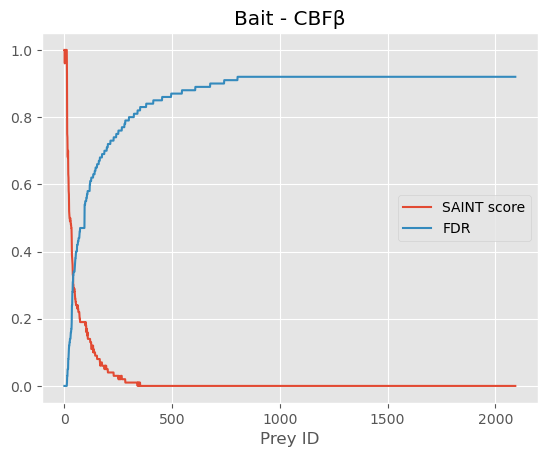

In [2]:
# Define possible prey for cbfb
cb_path = Path("../../data/raw/cullin_e3_ligase/")
cb = cullin_benchmark_test.CullinBenchMark(cb_path)
bait_id = "CBFBwt_MG132"
sel1 = cb.data["Bait"] == bait_id
sel2 = cb.data["SaintScore"] >= 0.3

cb.data = cb.data.loc[sel1, :]
# Visualize the data

def plot_saint_fdr(cb, title: str):
    plt.style.use('ggplot')
    plt.title(title)
    plt.plot(cb.data['SaintScore'], label='SAINT score')
    plt.plot(cb.data['BFDR'],  label="FDR")
    plt.legend()
    plt.xlabel('Prey ID')
    
title = u"Bait - CBF\u03B2"
plot_saint_fdr(cb, title=title)
# Look at the distribution of adjacency matices As

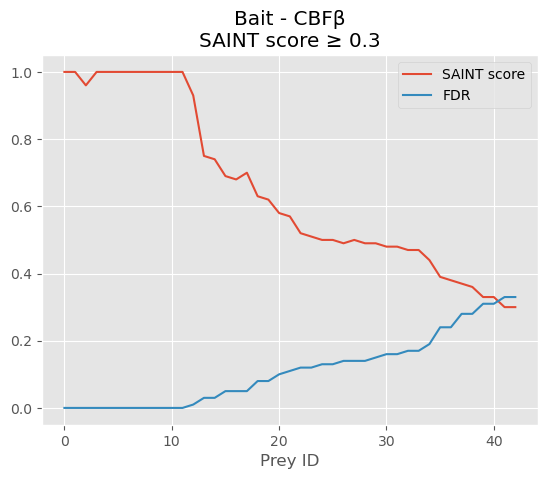

In [3]:
cb.data = cb.data.loc[sel2, :]
title2 = title + u"\nSAINT score \u2265 0.3"
plot_saint_fdr(cb, title=title2)

In [4]:
Ss = np.array(cb.data['SaintScore'])

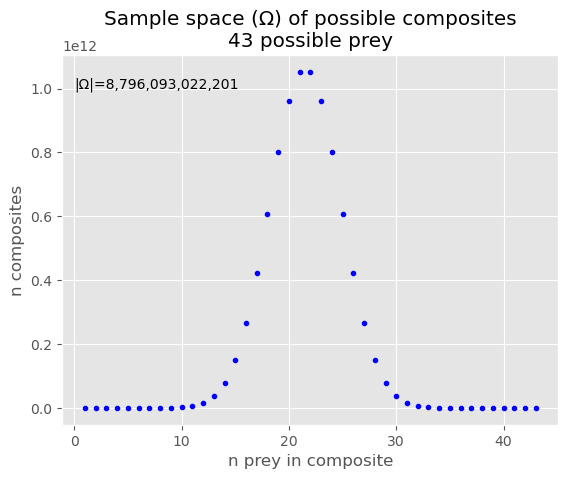

In [5]:
mp.plot_sample_space(Ss, textx=0, texty=1e12)

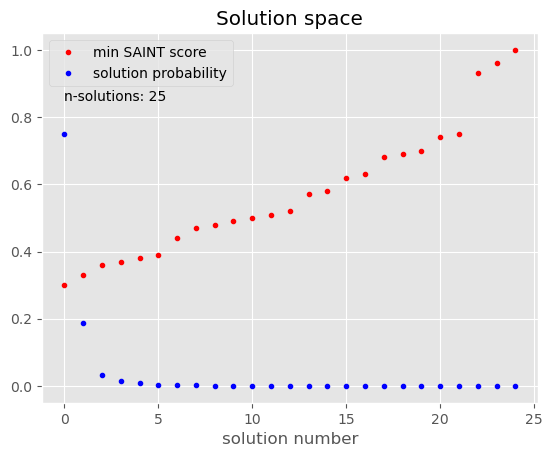

In [6]:
mp.plot_solution_space(Ss)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


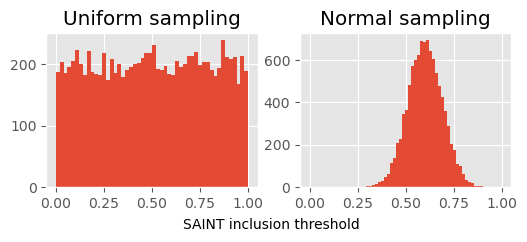

In [7]:
mp.plot_samples(Ss)

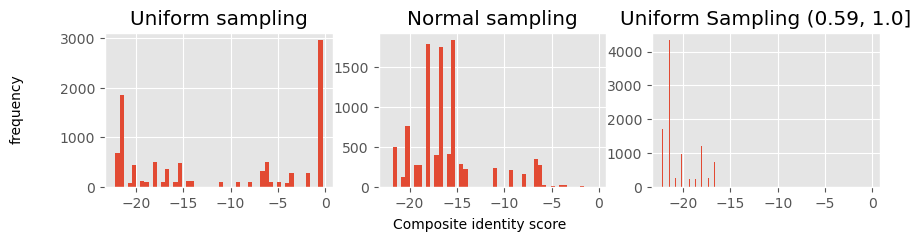

In [8]:
mp.plot_triple_samples(Ss)

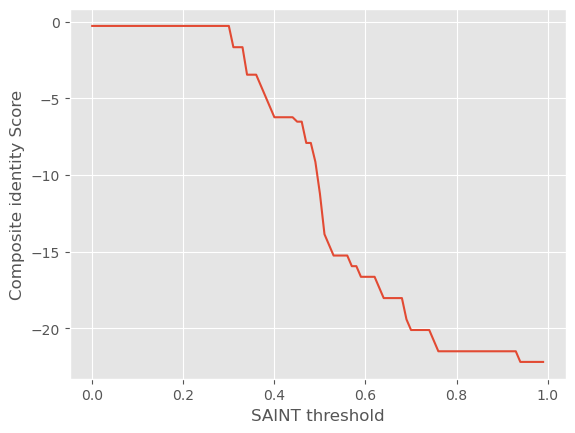

In [9]:
mp.plot_score_saint(Ss)

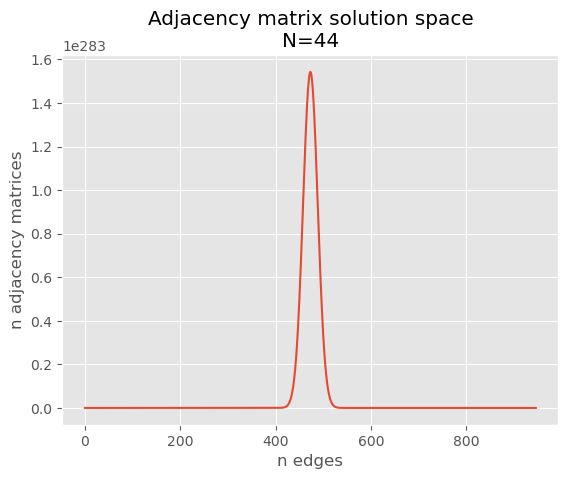

In [10]:
# Now what about enumerating Adjacency matrices?

_ = mp.plot_As_solution_space(44)

In [11]:
n_examples = 1000
p = 0.1
key = jax.random.PRNGKey(13)
n_edges = np.zeros(n_examples)
disconnectivity = np.zeros(n_examples)
for i in range(n_examples):
    key, k1 = jax.random.split(key)
    A = mp.proposal(k1, 44, n_examples, p=p)
    A = np.array(A, dtype=int)
    nedges = mp.nedges(A)
    n_edges[i] = nedges
    disconnectivity[i] = mp.d(A, np.arange(44))

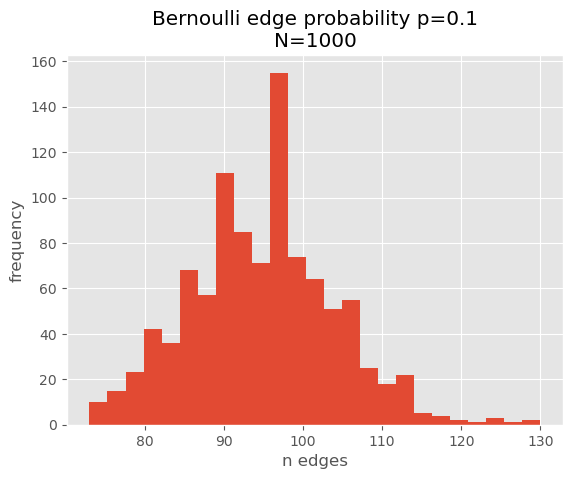

In [12]:
plt.hist(n_edges, bins=25)
plt.xlabel('n edges')
plt.ylabel('frequency')
plt.title(f'Bernoulli edge probability p={p}\nN={n_examples}')
plt.show()

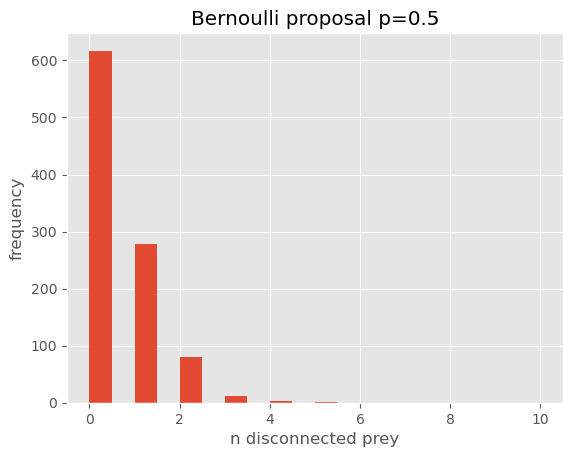

In [13]:
plt.hist(disconnectivity, bins=20, range=(0, 10))
plt.xlabel('n disconnected prey')
plt.ylabel('frequency')
plt.title('Bernoulli proposal p=0.5')
plt.show()

In [14]:
cb.parse_spec_counts()

In [15]:
# 1 Define M

N = 44
n_prey = 43

M = {"As": np.zeros((N, N), dtype=int),
     "Sigma_inv_s": np.eye(n_prey),
     "lambda_s": 0.5,
     "alpha_s": 0.5,
     "Cs": np.arange(44),
     "ts": 0.0,
     "mus": np.zeros(n_prey)}

I = {"Ss": Ss}


D = {"ds": cb.data.loc[:, ["r1", "r2", "r3", "r4"]].values}

assert D["ds"].shape == (43, 4)

# 2 Define the score function

# p(M| D, I) prop p(D | M, I)p(M|I)
#   p(M|I)
#     p(As|Cs, lambda_s)p(Cs|Ss, ts)p(ts)p(mus)

def log_pdf_ts(ts):
    return sp.stats.norm.logpdf(ts, loc=0.6, scale=0.08)

g_s = mp.log_pdf__M_D_I_restraint_builder(Ss, log_pdf_ts)
def log_prior(M):
    """
    Returns an array of log scores
    - As | Cs, lambda_s
    - Cs | Ss, ts
    - ts | I
    """
    return g_s(M["As"], M["Cs"], M["ts"], M["mus"], M["lambda_s"])

#  p(D| M, I)

def log_like(D, M) -> float:
    s = 0
    
    Y = D['ds']

    f = mp.log_pdf_yrs__mus_Sigma_inv_s
    mu_s = M['mus']
    Sigma_inv = M['Sigma_inv_s']
    As = M['As']
    alpha_s = M['alpha_s']
    
    for i in range(4):
        s += f(Y[:, i], mu_s, Sigma_inv)
    
    log_Sigma_inv = mp.log_pdf_Sigma_inv_s__As_alpha_s(Sigma_inv,
                                                      As,
                                                      alpha_s)
    return np.array([s, log_Sigma_inv])



def log_score(D, M):
    
    lp = log_prior(M)
    ll = log_like(D, M)
    
    return np.sum(lp) + np.sum(ll), ll, lp


# 3 Define the sampling

# 3.1 Define the movers
  # As
  # Sigma_inv - wish
  # mus - rand
  # 

# 3.2 Use MH Monte Carlo

# 3.3 Use simulated Annealing


# 3.4 Sample

# 3.5 Plot results


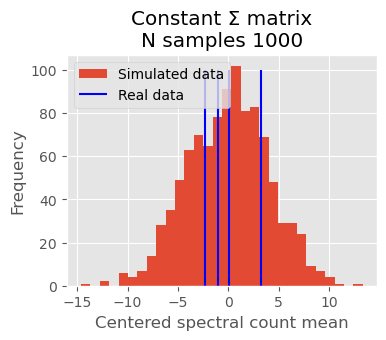

In [180]:
# Selecting the Wishart priors
# 
Y = D['ds']
mean = np.mean(Y, axis = 1).reshape((43, 1))
var = np.var(Y, axis=1).reshape((43, 1))
centered = Y - mean
Scatter = centered @ centered.T # Covariance space, add to the diagonal
Scatter = Scatter + jnp.eye(43) * 0.1
Sigma_inv_prior_guess = jsp.linalg.inv(Scatter)



V = 1/len(Sigma_inv_prior_guess) * Sigma_inv_prior_guess

z = mp._move_Sigma_inv(key, V, 43, 43)

# Prior predictive distribtuion for this scatter matrix

nsamples = 1000
key = jax.random.PRNGKey(13)
keys = jax.random.split(key, nsamples)
mean_sim = np.zeros(nsamples)
var_sim = np.zeros(nsamples)
sum_sim = np.zeros(nsamples)
for i in range(nsamples):
    y_sim = jax.random.multivariate_normal(keys[i], mean=np.zeros(43), cov=Scatter)
    mean_sim[i] = np.mean(y_sim)
    var_sim[i] = np.var(y_sim)
    sum_sim[i] = np.sum(y_sim)


    
def plot_hyper_param_predictive_check(sim_values, 
                                      real_values,
                                      real_operator,
                                      n_prey,
                                      nsamples,
                                      xlabel,
                                      title,
                                      w=4, h=3, sim_label='Simulated data',
                                     real_label='Real data',
                                     ):

    plt.figure(figsize=(w, h))
    plt.hist(sim_values, bins=30, label=sim_label)
    for i in range(4):

        if i == 3:
            plt.vlines(real_operator(real_values[:, i]), 0, 100, 'b', label=real_label)
        else:
            plt.vlines(real_operator(real_values[:, i]), 0, 100, 'b')
        plt.xlabel(xlabel)
    plt.legend()
    plt.title(title)
    plt.ylabel('Frequency')
    plt.show()
    
mean_plot = partial(plot_hyper_param_predictive_check, real_values=centered,
                   real_operator=np.mean,
                   n_prey=43,
                   nsamples=nsamples,
                   xlabel=f'Centered spectral count mean')

var_plot = partial(plot_hyper_param_predictive_check, real_values=centered,
                  real_operator=np.var,
                  n_prey=43,
                  nsamples=nsamples,
                  xlabel=f'Centered spectral count variance')

sum_plot = partial(plot_hyper_param_predictive_check, real_values=centered,
                  real_operator=np.sum,
                  n_prey=43,
                  nsamples=nsamples,
                  xlabel=f'Cenetered spectral count sum')


mean_plot(mean_sim, title=u'Constant \u03A3 matrix\nN samples ' + f'{nsamples}')

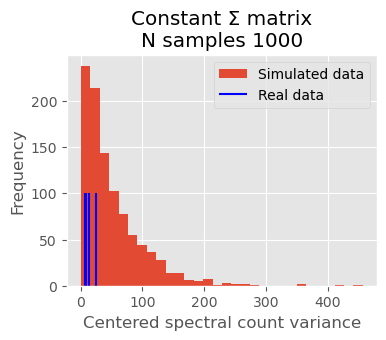

In [179]:
var_plot(var_sim, title=u'Constant \u03A3 matrix\nN samples ' + f'{nsamples}')

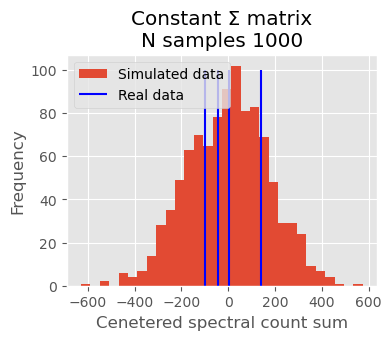

In [181]:
sum_plot(sum_sim, title=u'Constant \u03A3 matrix\nN samples ' + f'{nsamples}')

In [172]:
# Conclusion - the choice of the scatter matrix is reasonable

# Do an Experiment where we sample Covaraiance matrices and then sample data
def stepf(i, keys, n, mean_sim, var_sim, sum_sim):
    Sigma_inv_i = pynet_rng.wishart(keys[i + 1], V=V, n=n, p=43)
    Sigma_i = jsp.linalg.inv(Sigma_inv_i)
    y_sim = jax.random.multivariate_normal(keys[i], mean=jnp.zeros(43), cov=Sigma_i)
    
    x_ = jnp.mean(y_sim)
    v_ = jnp.var(y_sim)
    s_ = jnp.sum(y_sim)
    
    
    
    mean_sim = mean_sim.at[i].set(x_)
    var_sim = var_sim.at[i].set(v_)
    sum_sim = sum_sim.at[i].set(s_)
    return i, keys, n, mean_sim, var_sim, sum_sim


def do_sampled_sigma_experiment(nsamples, n, rseed):
    key = jax.random.PRNGKey(rseed)
    keys = jax.random.split(key, nsamples + 1)
    
    step = jax.jit(stepf)

    m = jnp.zeros(nsamples)
    v = jnp.zeros(nsamples)
    ss = jnp.zeros(nsamples)
    values = 0, keys, n, m, v, ss
    for i in range(nsamples):
        _, *x = values
        values = i, *x
        _, *x = step(*values)
        values = i, *x

    _, keys, _, m, v, ss = values
    return m, v, ss

m43, v43, ss43 = do_sampled_sigma_experiment(1000, 43, 13)
m50, v50, ss50 = do_sampled_sigma_experiment(1000, 50, 13)

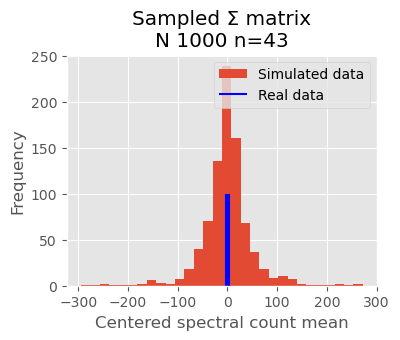

In [186]:
t0 = u'Sampled \u03A3 matrix' + f'\nN {nsamples} n='
mean_plot(np.array(m43), title=t0 + '43')

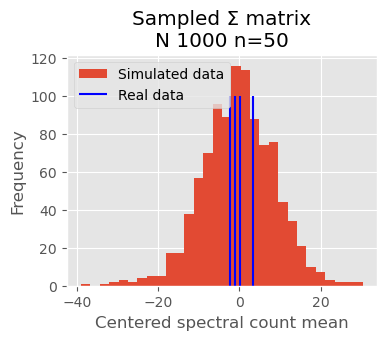

In [187]:
mean_plot(np.array(m50), title=t0 + '50')

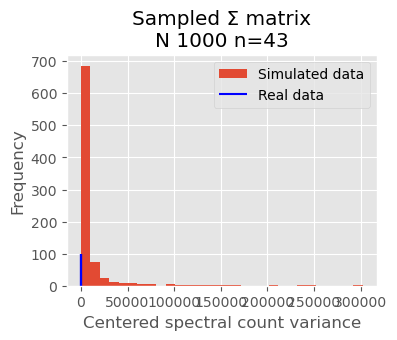

In [189]:
tv = u'Sampled \u03A3 matrix' + f'\nN {nsamples} n='
var_plot(v43,title=tv + '43')

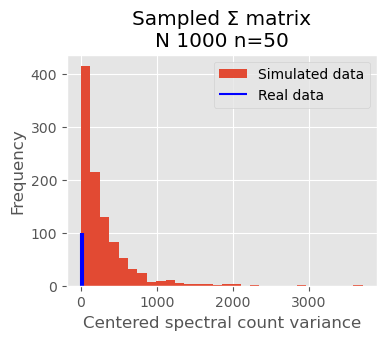

In [190]:
var_plot(v50, title=tv + '50')

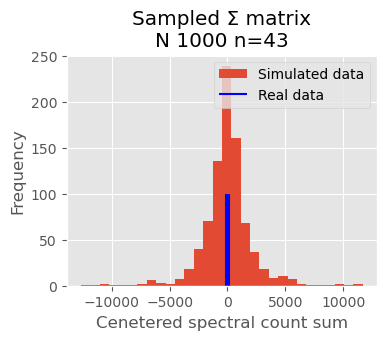

In [194]:
ts = u'Sampled \u03A3 matrix' + f'\nN {nsamples} n='
sum_plot(np.array(ss43), title=ts + '43')

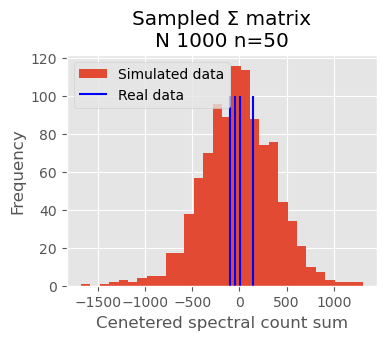

In [196]:
sum_plot(np.array(ss50), title=ts + '50')

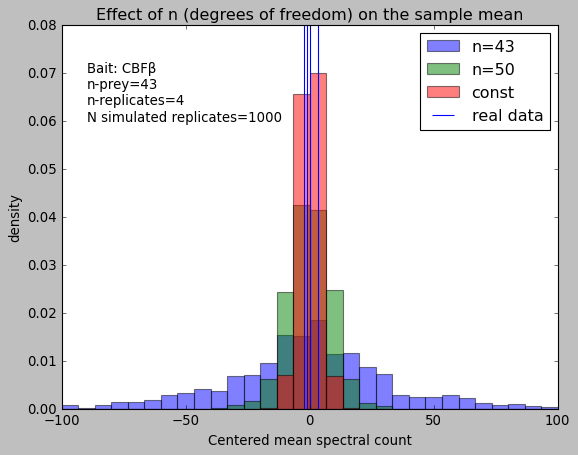

In [279]:
nbins=30
xmin = -100
xmax = 100

density = True

alpha= 0.5
hist = partial(plt.hist, bins=nbins, range=(xmin, xmax), density=density, alpha=alpha)

plt.style.use('classic')

hist(m43, label='n=43')
hist(m50, label='n=50')
hist(mean_sim, label='const')
plt.ylabel('density')
plt.xlabel('Centered mean spectral count')
plt.title('Effect of n (degrees of freedom) on the sample mean')

real_label='real data'
ymin = 0
ymax = 0.08
plt.vlines(np.mean(centered, axis=0), label=real_label, ymin=ymin, ymax=ymax)
textstr = u'Bait: CBF\u03B2\nn-prey=43\nn-replicates=4\nN simulated replicates=1000'
plt.text(-90, 0.06, textstr)
plt.legend()
plt.show()

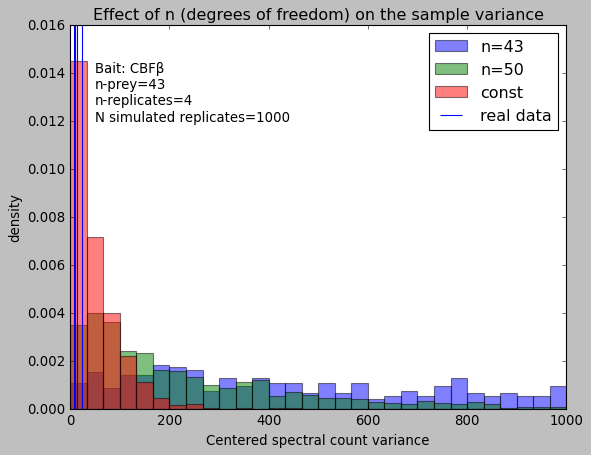

In [282]:
nbins=30
xmin = 0
xmax = 1000

density = True

alpha= 0.5
hist = partial(plt.hist, bins=nbins, range=(xmin, xmax), density=density, alpha=alpha)

plt.style.use('classic')

hist(v43, label='n=43')
hist(v50, label='n=50')
hist(var_sim, label='const')
plt.ylabel('density')
plt.xlabel('Centered spectral count variance')
plt.title('Effect of n (degrees of freedom) on the sample variance')
plt.text(50, 0.012, textstr)
plt.vlines(np.var(centered, axis=0), ymin=0, ymax=0.016, label=real_label)
plt.legend()
plt.show()

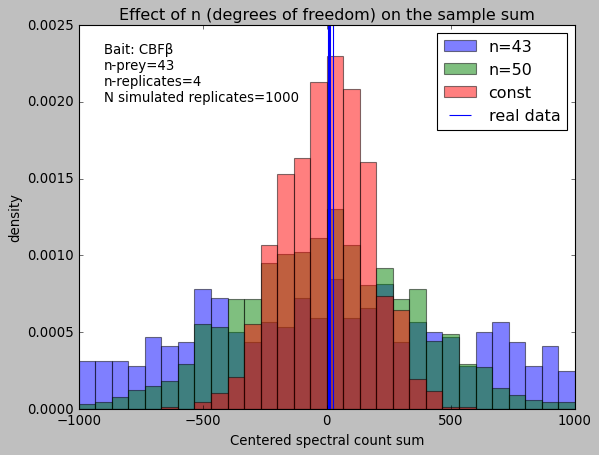

In [284]:
nbins=30
xmin = -1000
xmax = 1000

density = True

alpha= 0.5
hist = partial(plt.hist, bins=nbins, range=(xmin, xmax), density=density, alpha=alpha)

plt.style.use('classic')

hist(ss43, label='n=43')
hist(ss50, label='n=50')
hist(sum_sim, label='const')
plt.ylabel('density')
plt.xlabel('Centered spectral count sum')
plt.title('Effect of n (degrees of freedom) on the sample sum')
plt.text(-900, 0.002, textstr)
plt.vlines(np.var(centered, axis=0), ymin=0, ymax=0.0025, label=real_label)
plt.legend()
plt.show()

In [ ]:
# Conclusion - Setting a high n does in fact make the proposal / prior very broad.
# This analysis suggessts n should be set to 50 or more


In [18]:
# construct the proposal distribution
move_n_edges = 10
edge_prob = 0.5
n_prey = 43
size_As = 44

move_edges = mp._move_edges_j
move_edges = partial(move_edges, prob=edge_prob, n_edges=move_n_edges,n=n_prey)

def jit_move(key, M0):
    keys = jax.random.split(key, 4)
    
    A = M0['As']
    A1 = move_edges(keys[0], A)
    
    Sigma_inv_s = M0['Sigma_inv_s']
    Sigma_inv_s1 = mp._move_edges_j(keys[1], V, n_prey, n_prey)
    
    return M1_partial

jit_move = jax.jit(jit_move)(key, M)


def move_model(key, M0, proposal_params):
    """
    Take a step in parameter space
    Params:
      key - jax PRNG key
      M0  - The model dictionary at the current time step
      proposal_params - a dictionary to configure the proposal distribution
    Returns:
      M1  - The proposed model dictionary
    """
    
    
    
    
    return M1

NameError: name 'V' is not defined

In [ ]:
M['As']

In [ ]:
log_score(D, M)

In [ ]:
jax.random.randint(key, shape=(43,), minval=0, maxval=43)

In [ ]:
nsamples = 30
key = jax.random.PRNGKey(13)
keys = jax.random.split(key, nsamples + 1)
precision = pynet_rng.wishart(keys[0], jnp.eye(43), p=43, n=43)
for i in range(nsamples):
    precision = pynet_rng.wishart(keys[i + 1], precision, p=43, n=43)
    

In [ ]:
Y = D['ds']
mean = np.mean(Y, axis = 1).reshape((43, 1))
centered = Y - mean
S = Y @ Y.T
C = centered @ centered.T

In [ ]:
plt.imshow(S)
plt.colorbar()
print(np.mean(S), np.var(S))

In [ ]:
plt.imshow(C)
plt.colorbar()

In [ ]:
plt.imshow(precision)

In [ ]:
M['Sigma_inv_s']

In [ ]:
# plot a move of edges moving
A = M['As']
kernal = partial(mp._move_edges_j, n_edges = 11, n=len(A))
kernal = jax.jit(kernal)

n_frames = 100
key = jax.random.PRNGKey(13)
keys = jax.random.split(key, n_frames)
a = A

def create_frame(t, a):
    fig = plt.figure()
    a = kernal(keys[t], a, prob=0.5)
    a = np.array(a)
    
    plt.imshow(a)
    plt.title('Random Edge Sampling')
    plt.xlabel('j')
    plt.ylabel('i')
    plt.savefig(f'./img/03_log_composite_connectivity_prior__adjacency_example_{t}.png')
    plt.close()
    return a
    
for t in range(n_frames):
    a = create_frame(t, a)
    
frames = []
for t in range(n_frames):
    image = imageio.v2.imread(f'./img/03_log_composite_connectivity_prior__adjacency_example_{t}.png')
    frames.append(image)

# combine frames into a gif

In [ ]:
import imageio
imageio.mimsave('./gif/03_log_composite_connectivity_prior__adjacency_example.gif', frames, fps=5)

![SegmentLocal](./gif/03_log_composite_connectivity_prior__adjacency_example.gif "segment")

In [ ]:
a = create_frame(0, a)

In [ ]:
# Example GIF
import imageio
from IPython.display import Image
Image(filename="./img/img_0.png")
x = [1, 2, 3, 4, 4, 4, 4, 3, 2, 1, 1, 1, 1]
y = [1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 3, 2, 1]
time = list(range(13))
def create_frame(t):
    fig = plt.figure(figsize=(6, 6))    
    plt.plot(x[:(t+1)], y[:(t+1)], color = 'grey' )
    plt.plot(x[t], y[t], color = 'black', marker = 'o' )    
    plt.xlim([0,5])
    plt.xlabel('x', fontsize = 14)
    plt.ylim([0,5])
    plt.ylabel('y', fontsize = 14)
    plt.title(f'Relationship between x and y at step {t}',
              fontsize=14)    
    plt.savefig(f'./img/img_{t}.png', 
                transparent = False,  
                facecolor = 'white'
               )    
    plt.close()


create_frame(0)

# create a bunch of frames
for t in time:
    create_frame(t)

frames = []
for t in time:
    image = imageio.v2.imread(f"./img/img_{t}.png")
    frames.append(image)

# combine frames into a gif

imageio.mimsave('./gif/example.gif', frames, fps=5)

![SegmentLocal](./gif/example.gif "segment")

In [ ]:
plt.show('./img/img_0.png')

In [ ]:
# Plotting code

import itertools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams['animation.ffmpeg_path'] = '/home/aji/anaconda3/envs/pynetp3.10.0/bin/ffmpeg'


fig, ax = plt.subplots()
im = ax.imshow(A)

n_frames = 100
key = jax.random.PRNGKey(13)
keys = jax.random.split(key, n_frames)
def init():
    return im

def func(frame):
    
    index = int(frame)
    a = kernal(keys[index], a, prob=0.5)
    a = np.array(a)
    im.set_data(a)
    return im

ani = animation.FuncAnimation(fig, func, data_gen, interval=n_frames, init_func=init,
                              save_count=100)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
mp._move_edges_j(key, A, prob=0.5, n_edges=2, n=10)

In [ ]:
def init():
    A = np.array(A)
    im = ax.imshow(A)
    return im
    
def func(A):
    A = np.array(A)
    im = ax.imshow(A)
    return im

#for frame in range(n_frames):
    #a = kernal(keys[frame], a, prob=0.5)
    

ani = animation.FuncAnimation(fig, func, data_gen, interval=100, init_func=init,
                              save_count=100)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
?ax.imshow


In [ ]:


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=1000)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
?animation.FuncAnimation

In [ ]:
plt.show(ani)

In [ ]:
%%bash
which ffmpeg

In [ ]:
loc = 0.6
scale = 0.08
x = np.arange(-1 + loc, 1.1 + loc, 0.1)
plt.plot(x, sp.stats.norm.logpdf(x, loc=loc, scale=scale))

In [ ]:
Ak = np.tril(A, k=-1)
U = np.triu(np.ones((44, 44)))
Ak = Ak + U

In [ ]:
plt.imshow(Ak)

In [ ]:
i_s, j_s = np.where(Ak == 0)

In [ ]:
A[i_s, j_s]

In [ ]:
cb.data.loc[:, ["r1", "r2", "r3", "r4"]].values

In [ ]:
mp.d(np.zeros((44, 44), dtype=int), np.arange(44))

In [ ]:
lambdas = [0.1, 1, 10]
def gen_data(lambda_s, density=False):
    ys = []
    xs = []
    for i in range(1, len(A)+1):
        Cs = np.arange(i)

        n_dis = m.d(A, Cs)
        score = m.log_pdf_As__Cs_lambda_s(A, Cs, lambda_s)
        ys.append(score)
        xs.append(n_dis)
    if density:
        xs = xs
        ys = np.exp(ys)
    return xs, ys
        
density = True
xs, ys = gen_data(0.1, density=density)
xs_1, ys_1 = gen_data(1, density=density)
xs_10, ys_10 = gen_data(2, density=density)


In [ ]:
def plot_composite_connectivity():
    plt.title("Composite connectivity restraint")
    plt.style.use('ggplot')
    plt.plot(xs, ys, 'g.', label=u'\u03BB 0.1')
    plt.plot(xs_1, ys_1, 'r.', label=u'\u03BB 1')
    plt.plot(xs_10, ys_10, 'b.', label=u'\u03BB 10')
    plt.xlabel('Disconnected prey')
    plt.ylabel('P(As | Cs, lambda_s)')
    plt.legend()

##### plt.title("Composite connectivity log density")
plt.style.use('ggplot')
plt.plot(xs, np.log(ys), 'g-', label=u'\u03BB 0.1')
plt.plot(xs_1, np.log(ys_1), 'r-', label=u'\u03BB 1')
plt.plot(xs_10, np.log(ys_10), 'b-', label=u'\u03BB 10')
plt.xlabel('Disconnected prey')
plt.ylabel('log P(As | Cs, lambda_s)')
plt.legend()